## Online available

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/carlos-adir/FEM-NURBS/blob/main/2-Poisson/1-laplace-basic.ipynb)

This python notebook is available online in GitHub throught:

* [GitHub/carlos-adir/FEM-NURBS/2-Poisson/1-laplace-basic.ipynb](https://github.com/carlos-adir/FEM-NURBS/blob/main/2-Poisson/1-laplace-basic.ipynb)

In [1]:
try:
    from compmec import nurbs
except ModuleNotFoundError:
    import os
    os.system("pip install numpy")
    os.system("pip install mpmath")
    os.system("pip install matplotlib")
    os.system("pip install compmec-nurbs")
import numpy as np
from typing import Callable, Iterable, Optional, Tuple
from matplotlib import pyplot as plt
from compmec import nurbs  
from helpernurbs import getH, getD, Fit
from helperlinalg import solve_system
from ploter import plot_field

# Laplace Equation

The Laplace Equation is given by

$$\nabla^2 T = 0 \ \ \text{on} \ \Omega$$

In 2D, we can transform it into

$$
\mu_x \dfrac{\partial^2 T}{\partial x^2} + \mu_y \dfrac{\partial^2 T}{\partial y^2} = f(x, \ y) \ \ \ \ \ \text{on} \ \ \Omega  
$$

With two non-zero constants $\mu_x$, $\mu_y \in \mathbb{R}$. By Galerking formulation

$$
\int_{\Omega} \left(\mu_x\dfrac{\partial^2 T}{\partial x^2} + \mu_y\dfrac{\partial^2 T}{\partial y^2} \right) \cdot \varphi \ d\Omega = 0 \ \ \ \forall \varphi
$$

Taking $\varphi = N_{i,px}(x) \cdot N_{j,py}(y)$, and expanding $T$ we get

$$\begin{align*}\int_{\Omega} \dfrac{\partial^2 T}{\partial x^2} \varphi \ d\Omega & = \sum_{a, \ b} \int_{0}^{1}\int_{0}^{1} \dfrac{d^2N_{a,px}}{dx^2} \ N_{b,py} \ N_{i,px} \ N_{j,py} \ dx dy \\ & = \sum_{a, \ b} \left(\int_{0}^{1}N_{i,px} \dfrac{d^2N_{a,px}}{dx^2} \ dx \right)\left(\int_{0}^{1}N_{j,py} N_{b,py} \ dy \right) \\ & = \sum_{a, \ b} \left[\mathbf{H}_{02}^{x}\right]_{ia} \cdot \left[\mathbf{H}_{00}^{y}\right]_{jb}\end{align*}$$

Therefore

$$\int_{\Omega} \dfrac{\partial^2 T}{\partial x^2} \varphi \ d\Omega \equiv \left[\mathbf{H}_{02}^{x}\right] \otimes \left[\mathbf{H}_{00}^{y}\right] $$
$$
\int_{\Omega} \dfrac{\partial^2 T}{\partial y^2} \varphi \ d\Omega \equiv \left[\mathbf{H}_{00}^{x}\right] \otimes \left[\mathbf{H}_{02}^{y}\right]
$$

Therefore

$$\left[\mathbf{A}\right] = \mu_x \cdot \left[\mathbf{H}_{02}^{x}\right] \otimes \left[\mathbf{H}_{00}^{y}\right] + \mu_y \cdot \left[\mathbf{H}_{00}^{x}\right] \otimes \left[\mathbf{H}_{02}^{y}\right] $$

As $f(\mathbf{x}) = 0$, then $\left[\mathbf{B}\right] = \left[\mathbf{0}\right]$


In [2]:
def mountA(Nx, Ny, mux: float, muy: float) -> np.ndarray:
    Hx00 = getH(Nx, 0, 0)
    Hx02 = getH(Nx, 0, 2)
    Hy00 = getH(Ny, 0, 0)
    Hy02 = getH(Ny, 0, 2)
    A = mux*np.tensordot(Hx02, Hy00, axes=0)
    A += muy*np.tensordot(Hx00, Hy02, axes=0)
    return A

### Example 1

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> On the domain
> 
> $$\Omega = \left(0, \ 1\right) \times \left(0, \ 1\right)$$
>
> And Dirichlet boundary conditions
>
> $$\begin{align*} T(x, \ 0) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\ T(x, \ 1) & = \sin \pi x \ \ \ \ \ 0 \le x \le 1 \\ T(0, \ y) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 < y < 1 \\ T(1, \ y) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ 0 < y < 1 \end{align*}$$
> 
> The analitic solution is given by
> 
> $$T_{analitic}(x, \ y) = \dfrac{\sinh (\pi y) \sin (\pi x)}{\sinh \pi}$$


In [3]:
nx, ny = 11, 13
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

BC_up = lambda x: np.sin(np.pi*x)
Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = 0  # T(x, 0) = 0
Tvals[0, 1:-1] = 0  # T(0, y) = 0
Tvals[:,ny-1] = Fit.spline_curve(Nx, BC_up)  # T(x, 1) = sin(pi*x)
Tvals[nx-1,1:-1] = 0  # T(1, y) = 0

A = mountA(Nx, Ny, 1, 1)
B = np.zeros((nx, ny))
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

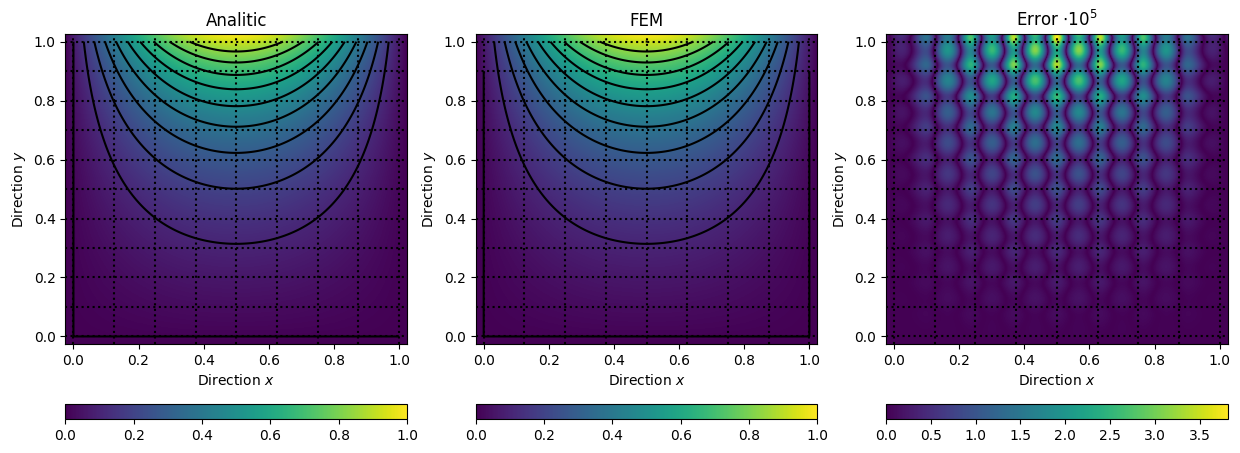

In [4]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly
exavalues = np.tensordot(np.sin(np.pi*xplot), np.sinh(np.pi*yplot), axes=0)/np.sinh(np.pi)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))
plot_field(xplot, yplot, exavalues, axis[0])
plot_field(xplot, yplot, femvalues, axis[1])
error = np.abs(femvalues-exavalues)
factor = np.ceil(np.log10(1/np.max(error)))
plot_field(xplot, yplot, error*10**factor, axis[2], contour=False)

axis[0].set_title(r"Analitic")
axis[1].set_title(r"FEM")
axis[2].set_title(r"Error $\cdot 10^{%d}$"%factor)
for i in range(3):
    axis[i].set_xlabel(r"Direction $x$")
    axis[i].set_ylabel(r"Direction $y$")
    [axis[i].axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
    [axis[i].axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]

### Example 2

> $$\dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} = 0$$ 
>
> On the domain
> 
> $$\Omega = \left(0, \ 1\right) \times \left(0, \ 1\right)$$
>
> And boundary conditions
>
> $$\begin{align*}T(x, \ 0) & = 0 \ \ \ \ \ 0 \le x \le 1 \\ T(x, \ 1) & = 1 \ \ \ \ \ 0 \le x \le 1 \\
T(0, \ y) & = 0 \ \ \ \ \ 0 < y < 1 \\ T(1, \ y) & = 0 \ \ \ \ \ 0 < y < 1 \end{align*}$$

In [5]:
nx, ny = 11, 13
px, py = 3, 4
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

BC_at_x0 = np.zeros(len(ysample))
BC_at_y0 = np.zeros(len(xsample))
BC_at_x1 = np.zeros(len(ysample))
BC_at_y1 = np.ones(len(xsample))
Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.linalg.lstsq(Lx.T, BC_at_y0, rcond=0)[0]  # T(x, 0)
Tvals[0, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x0, rcond=0)[0]  # T(0, y)
Tvals[:, ny-1] = np.linalg.lstsq(Lx.T, BC_at_y1, rcond=0)[0]  # T(x, 1)
Tvals[nx-1, 1:-1] = np.linalg.lstsq(Ly[1:-1].T, BC_at_x1, rcond=0)[0]  # T(1, y)

A = mountA(Nx, Ny, 1, 1)
B = np.zeros((nx, ny))
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

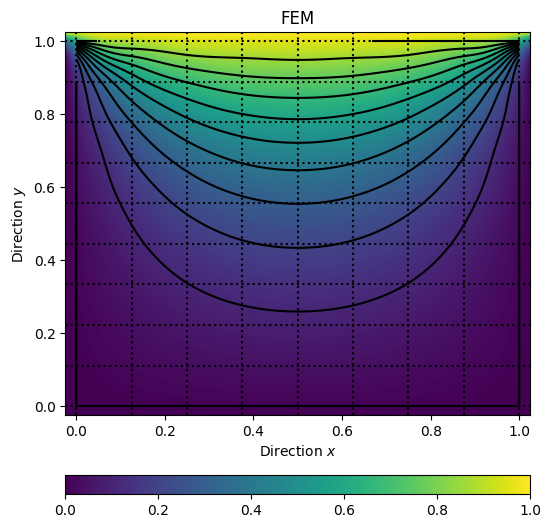

In [6]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
axis.set_xlabel(r"Direction $x$")
axis.set_ylabel(r"Direction $y$")
axis.set_title(r"FEM")

### Example 3

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> On the domain
> 
> $$\begin{align*} S & = \left[0, \ 1\right] \times \left[0, \ 1\right] \\ C & = \left[0.4, \ 0.6\right] \times \left[0.4, \ 0.6\right]  \\ \Omega & = S \setminus C \end{align*}$$
> 
> And boundary conditions
> 
> $$\begin{align*} T(x, \ 0) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\ T(x, \ 1) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\ T(0, \ y) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\ T(1, \ y) & = 0   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\ T(x, \ y) & = 1   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \forall \left(x, \ y\right) \in C \end{align*}$$

In [7]:
nx, ny = 41, 41
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
for U in [Ux, Uy]:
    for knot in [0.4, 0.6]:
        if U.degree == U.mult(knot):
            continue
        U.knot_insert(knot, U.degree-int(U.mult(knot)))
nx, ny = Ux.npts, Uy.npts
spanx04, spanx06 = Ux.span([0.4, 0.6]) 
spany04, spany06 = Uy.span([0.4, 0.6])
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, 0] = np.zeros(nx)  # T(x, 0)
Tvals[0, :] = np.zeros(ny)   # T(0, y)
Tvals[:, ny-1] = np.zeros(nx)   # T(x, 1)
Tvals[nx-1, :] = np.zeros(ny)  # T(1, y)
Tvals[spanx04-px:spanx06+1-px, spany04-py:spany06+1-py] = 1

A = mountA(Nx, Ny, 1, 1)
B = np.zeros((nx, ny))
# Adicionamos a condicao de conxorno de Neumann quando y = 1
Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

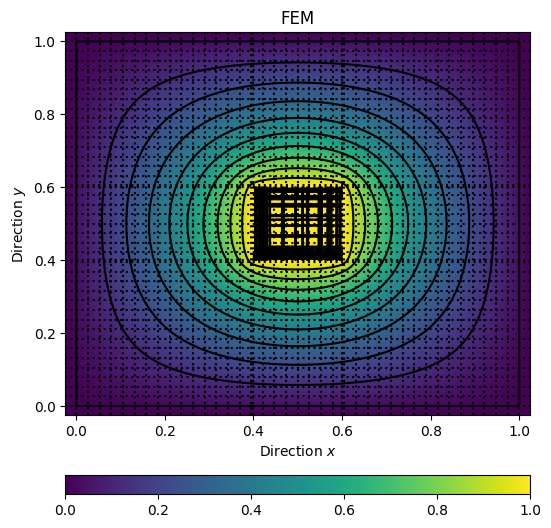

In [8]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
# axis.plot((0.4, 0.4, 0.6, 0.6, 0.4), (0.4, 0.6, 0.6, 0.4, 0.4), color="w", lw= 5)
axis.set_ylabel(r"Direction $y$")
axis.set_xlabel(r"Direction $x$")
axis.set_title(r"FEM")

### Example 4

Using the symmetry of the example 3 with respect to $x=0.5$ and $y=0.5$ we can reformulate the problem as:

> $$\dfrac{\partial^2 T}{\partial x^2}+\dfrac{\partial^2 T}{\partial y^2} = 0$$
> 
> On
> 
> $$\begin{align*} S & = \left[0, \ 1\right] \times \left[0, \ 1\right] \\ C & = \left[0, \ 0.2\right] \times \left[0, \ 0.2\right]  \\ \Omega & = \left(S \setminus C \right) \end{align*}$$
> 
> And boundary conditions
> 
> $$\begin{align*} \dfrac{\partial T}{\partial y}(x, \ 0) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0.2 < x \le 1 \\ T(x, \ 1) & = 0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le x \le 1 \\ \dfrac{\partial T}{\partial x}(0, \ y) & = 0  \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0.2 < y \le 1 \\ T(1, \ y) & = 0   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 0 \le y \le 1 \\ T(x, \ y) & = 1   \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \forall \left(x, \ y\right) \in C \end{align*}$$

In [9]:
nx, ny = 21, 21
px, py = 3, 3
Ux = nurbs.GeneratorKnotVector.uniform(px, nx)
Uy = nurbs.GeneratorKnotVector.uniform(py, ny)
knotx, knoty = 0.2, 0.3
if Ux.degree != Ux.mult(knotx):
    Ux.knot_insert(knotx, Ux.degree-int(Ux.mult(knotx)))
if Uy.degree != Uy.mult(knoty):
    Uy.knot_insert(knoty, Uy.degree-int(Uy.mult(knoty)))
    
nx, ny = Ux.npts, Uy.npts
spanx = Ux.span(knotx) 
spany = Uy.span(knoty)
Nx = nurbs.SplineBaseFunction(Ux)
Ny = nurbs.SplineBaseFunction(Uy)
xsample = np.linspace(0, 1, 4*nx)
ysample = np.linspace(0, 1, 4*ny)
Lx, Ly = Nx(xsample), Ny(ysample)

Tvals = np.empty((nx, ny))
Tvals.fill(np.nan)
Tvals[:, ny-1] = np.zeros(nx)   # T(x, 1)
Tvals[nx-1, :] = np.zeros(ny)  # T(1, y)
Tvals[:spanx+1-px, :spany+1-py] = 1

A = mountA(Nx, Ny, 1, 1)
B = np.zeros((nx, ny))

# Adicionar condição de Neumann
xsample = np.linspace(knot, 1, 4*nx)
ysample = np.linspace(knot, 1, 4*ny)
q_at_x0 = np.zeros(ysample.shape, dtype="float64")
q_at_y0 = np.zeros(xsample.shape, dtype="float64")
Lx, Ly = Nx[spanx+1-px:nx-1](xsample), Ny[spany+1-py:ny-1](ysample)
B[0, spany+1-py:ny-1] = np.linalg.lstsq(Ly.T, q_at_x0, rcond=None)[0]
B[spanx+1-px:nx-1, 0] = np.linalg.lstsq(Lx.T, q_at_y0, rcond=None)[0]
Rx = getD(px, Ux) @ Nx[:,px-1](0)
Ry = getD(py, Uy) @ Ny[:,py-1](0)
for i in range(nx):  # 
    A[i, i, 0, :] = Rx[:]
for j in range(ny):
    A[0, :, j, j] = Ry[:]

Tvals, _ = solve_system(A, B, Tvals)

Text(0.5, 1.0, 'FEM')

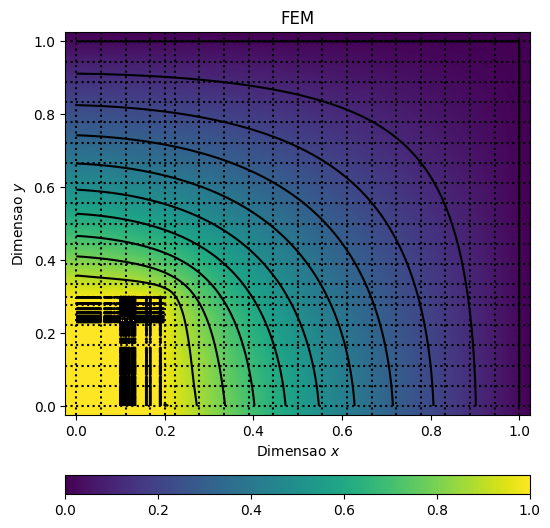

In [10]:
xplot = np.linspace(0, 1, 1025)
yplot = np.linspace(0, 1, 1025)
Lx, Ly = Nx(xplot), Ny(yplot)

femvalues = Lx.T @ Tvals @ Ly

fig = plt.figure(figsize=(6,6))
axis = plt.gca()
plot_field(xplot, yplot, femvalues, axis)
[axis.axvline(x=xi, ls="dotted", color="k") for xi in list(set(Ux))]
[axis.axhline(y=yi, ls="dotted", color="k") for yi in list(set(Uy))]
# axis.plot((0.4, 0.4, 0.6, 0.6, 0.4), (0.4, 0.6, 0.6, 0.4, 0.4), color="w", lw= 5)
axis.set_ylabel(r"Dimensao $y$")
axis.set_xlabel(r"Dimensao $x$")
axis.set_title(r"FEM")